<a href="https://colab.research.google.com/github/nafizahamed8/Deep-Learning/blob/main/Implementing_Deep_CNN_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
from torchvision import transforms

#***an image into a PyTorch tensor***

In [ ]:
import torchvision
from torchvision import transforms
image_path='./'
transform=transforms.Compose([transforms.ToTensor()])

In [ ]:
mnist_dataset=torchvision.datasets.MNIST(root=image_path,
                                         train=True,download=True,transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.50MB/s]


In [ ]:
from torch.utils.data import Subset
import torch
mnist_valid_dataset=Subset(mnist_dataset,torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset,
torch.arange(10000, len(mnist_dataset)))

In [ ]:
mnist_test_dataset=torchvision.datasets.MNIST(root=image_path,train=False,download=False,transform=transform)

#***data loader with batches of 64 images for the training set and validation set***

In [ ]:
from torch.utils.data import DataLoader
batch_size=64
torch.manual_seed(1)
train_d1=DataLoader(mnist_train_dataset,batch_size=batch_size,shuffle=True)
valid_d1=DataLoader(mnist_valid_dataset,batch_size=batch_size,shuffle=False)

#***Implementing CNN with PyTorch.nn module***

In [ ]:
from torch import nn
model=nn.Sequential()
model.add_module('conv1',nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,
                                   padding=1))
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))
model.add_module('conv2',nn.Conv2d(in_channels=32, out_channels=64,kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [ ]:
x=torch.ones(4,1,28,28)
model(x).shape

torch.Size([4, 64, 7, 7])

In [ ]:
model.add_module('flatten',nn.Flatten())
model(x).shape

torch.Size([4, 3136])

In [ ]:
model.add_module('fc1',nn.Linear(3136,1024))
model.add_module('relu3',nn.ReLU())
model.add_module('dropout',nn.Dropout(p=0.5))
model.add_module('fc2',nn.Linear(1024,10))

In [ ]:
ls_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def train(model,num_of_epochs,train_dl,valid_d1):
  loss_hist_train=[0]*num_of_epochs
  accuracy_hist_train=[0]*num_of_epochs
  loss_hist_valid=[0]*num_of_epochs
  accuracy_hist_valid=[0]*num_of_epochs

  for epoch in range(num_of_epochs):
    model.train()
    for x_batch,y_batch in train_dl:
      pred=model(x_batch)
      loss=ls_fn(pred,y_batch)
      loss.backward()#counts the gradient of every parameter
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch]+=loss.item()*y_batch.size(0)
      is_correct=(torch.argmax(pred,dim=1)==y_batch).float()
      accuracy_hist_train[epoch]+=is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
       for x_batch,y_batch in valid_d1:
           pred=model(x_batch)
           loss=ls_fn(pred,y_batch)
           loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
           is_correct=(torch.argmax(pred,dim=1),y_batch).float()
           accuracy_hist_valid[epoch]+=is_correct.sum()
  loss_hist_valid[epoch]/=len(valid_d1.dataset)
  accuracy_hist_valid[epoch]/=len(valid_d1.dataset)
  print(f'Epoch {epoch+1} accuracy: '
f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
f'{accuracy_hist_valid[epoch]:.4f}')


  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



#***Training the model on GPU***

In [ ]:
torch.manual_seed(1)
num_epochs = 20
# Check for GPU availability and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Move the model to the device
model.to(device)

# Modify the train function to move data to the device
def train(model, num_of_epochs, train_dl, valid_d1):
  loss_hist_train = [0] * num_of_epochs
  accuracy_hist_train = [0] * num_of_epochs
  loss_hist_valid = [0] * num_of_epochs
  accuracy_hist_valid = [0] * num_of_epochs

  for epoch in range(num_of_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      # Move data to the device
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)

      pred = model(x_batch)
      loss = ls_fn(pred, y_batch)
      loss.backward()  # counts the gradient of every parameter
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item() * y_batch.size(0)
      is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.sum()
    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      for x_batch, y_batch in valid_d1:
        # Move data to the device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        pred = model(x_batch)
        loss = ls_fn(pred, y_batch)
        loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_valid[epoch] += is_correct.sum()
    loss_hist_valid[epoch] /= len(valid_d1.dataset)
    accuracy_hist_valid[epoch] /= len(valid_d1.dataset)
    print(f'Epoch {epoch+1} accuracy: '
          f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
          f'{accuracy_hist_valid[epoch]:.4f}')


  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

hist = train(model, num_epochs, train_d1, valid_d1)

Using device: cuda
Epoch 1 accuracy: 0.9485 val_accuracy: 0.9802
Epoch 2 accuracy: 0.9844 val_accuracy: 0.9871
Epoch 3 accuracy: 0.9895 val_accuracy: 0.9858
Epoch 4 accuracy: 0.9918 val_accuracy: 0.9900
Epoch 5 accuracy: 0.9930 val_accuracy: 0.9908
Epoch 6 accuracy: 0.9944 val_accuracy: 0.9873
Epoch 7 accuracy: 0.9950 val_accuracy: 0.9888
Epoch 8 accuracy: 0.9962 val_accuracy: 0.9901
Epoch 9 accuracy: 0.9966 val_accuracy: 0.9886
Epoch 10 accuracy: 0.9973 val_accuracy: 0.9905
Epoch 11 accuracy: 0.9973 val_accuracy: 0.9900
Epoch 12 accuracy: 0.9974 val_accuracy: 0.9895
Epoch 13 accuracy: 0.9977 val_accuracy: 0.9918
Epoch 14 accuracy: 0.9981 val_accuracy: 0.9898
Epoch 15 accuracy: 0.9982 val_accuracy: 0.9918
Epoch 16 accuracy: 0.9983 val_accuracy: 0.9911
Epoch 17 accuracy: 0.9981 val_accuracy: 0.9914
Epoch 18 accuracy: 0.9983 val_accuracy: 0.9912
Epoch 19 accuracy: 0.9985 val_accuracy: 0.9908
Epoch 20 accuracy: 0.9986 val_accuracy: 0.9907


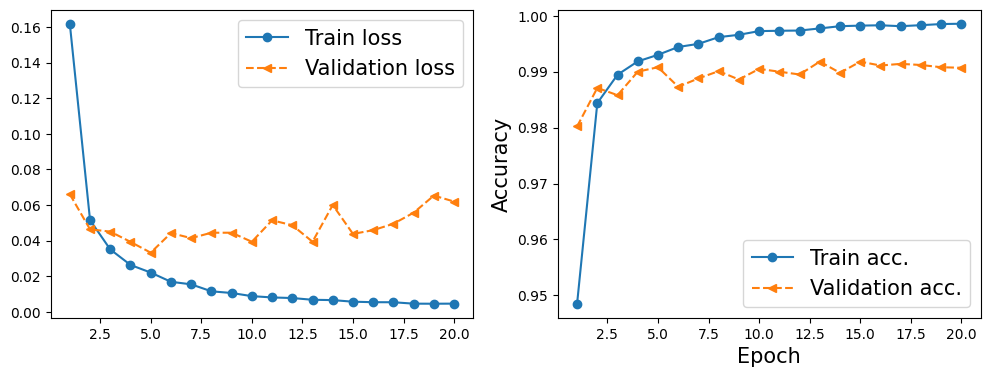

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
# Move tensors to CPU before converting to NumPy
ax.plot(x_arr, [acc.cpu() for acc in hist[2]], '-o', label='Train acc.')
ax.plot(x_arr, [acc.cpu() for acc in hist[3]], '--<',
label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
# Move the test data to the same device as the model
test_data_device = mnist_test_dataset.data.unsqueeze(1).to(device) / 255.0
pred = model(test_data_device)

# Move the test targets to the same device as the model for comparison
test_targets_device = mnist_test_dataset.targets.to(device)

is_correct = (torch.argmax(pred, dim=1) == test_targets_device).float()
print(f'test accuracy: {is_correct.mean():.4f}')

test accuracy: 0.9917


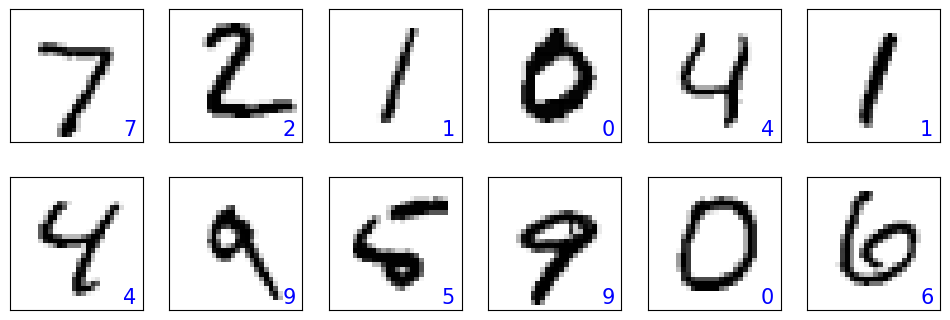

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    # Move the image tensor to the GPU
    img_device = img.unsqueeze(0).unsqueeze(1).to(device)
    pred = model(img_device)
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
    size=15, color='blue',
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax.transAxes)
plt.show()